In [99]:
from typing import List, Dict, Optional, Any
from typing_extensions import TypedDict
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
import os 
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import  StateGraph, END
from tabulate import tabulate
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
import pandas as pd
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [100]:
#define LLM
#Define LLM
model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY
)


In [102]:
#agent state
class AgentState(TypedDict):
    query: str 
    route : List[str] 
    product_vector_result : str
    vehicle_vector_result : str
    contract_vector_result : str
    rewritten_query: str 
    contract_filters: str
    vehicle_filters: str
    product_filters: str
    final_answer : str 
    trace : List[List[str]]
    customer_id: str
    quote_step: str
    quote_filters: Dict[str, Any]
    quote_vehicle_candidates: List[Dict[str, Any]]
    quote_product_candidates: List[Dict[str, Any]]
    quote_final_vehicle: Optional[Dict[str, Any]]
    quote_final_product: Optional[Dict[str, Any]]
    quote: Optional[Dict[str, Any]]
    quote_intermediate_results: str 
    quote_next_agent: str  
    quote_context: str
    quote_completed: bool
    quote_results : str

In [103]:
#load Database
embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
vehicle_vector_db = FAISS.load_local("vehicle_faiss", embeddings, allow_dangerous_deserialization= True)
product_vector_db = FAISS.load_local("product_faiss", embeddings, allow_dangerous_deserialization= True)
contract_vector_db = FAISS.load_local("contracts_faiss", embeddings, allow_dangerous_deserialization= True)


In [104]:
# define quotation data
vehicle_df = pd.read_csv("vehicle_data.csv")  # your dataset
product_df = pd.read_csv("leasing_data.csv")  # your dataset


def filter_df(df: pd.DataFrame, filters: Dict[str, Any]) -> pd.DataFrame:
    for key, value in filters.items():
        if isinstance(value, tuple):  # numeric range
            df = df[(df[key] >= value[0]) & (df[key] <= value[1])]
        else:
            df = df[df[key] == value]
    return df

In [105]:
# router template
router_template = """
You are a **Contract Query Router** inside a vehicle-leasing system. 
Your job is to take any user query in natural language and turn it into:
- A rewritten, clarified query
- Structured filters for searching Contract DB, Vehicle DB, and Product DB
- A routing plan (which DBs to query)

---
### Knowledge of Fields

**Contract fields**:
- customer_id
- existing_customer (Yes/No)
- vehicle_id
- product_id
- monthly_emi
- lease_start_date
- lease_expiry_date
- road_assistance (Yes/No)
- maintenance (Yes/No)
- discount_applied
- preferred_customer (Yes/No)

**Vehicle fields**:
- country
- make
- model
- year
- mileage
- fuel
- gear_type
- horsepower
- price
- currency
- preowned (Yes/No)
- inserted_date

**Product fields**:
- product_name
- short_description
- lease_term
- flexi_lease (Yes/No)
- tax_saving_plan (Yes/No)
- renewal_cycle
- maintenance_type
- inserted_date

---
### Query Understanding Rules

1. **Rewrite the query**
   - Normalize vague words into explicit meaning (e.g., “ongoing contracts” → “contracts where lease_expiry_date >= today”).
   - Expand short questions into complete sentences if needed.
   - Keep the rewritten query user-friendly but explicit.

2. **Extract filters**
   - Identify which fields are implied by the user query.
   - If a filter is implied but not exact, still output it. Examples:
     - “current” / “active” / “ongoing” → `lease_expiry_date >= today`
     - “expired contracts” → `lease_expiry_date < today`
     - “my SUV contracts” → Vehicle filter `Model : SUV`
     - “maintenance included” → Contract filter `Maintenance: Yes`
     - “roadside help” → Contract filter `road_assistance: Yes`
     - “flexi lease” → Product filter `flexi_lease: Yes`
     - **"quotation" / "lease quote" / "lease quotation"** → indicate that query should route to quotation flow

3. **Routing decision**
   - If user mentions “contract”, or asks about my agreements, route includes `"contract"`.
   - If query contains vehicle details (make, model, fuel, mileage, horsepower), include `"vehicle"`.
   - If query contains product/plan terms (lease term, flexi lease, tax saving, EMI, renewal, maintenance type), include `"product"`.
   - If query asks about **leasing quotation** or **quote for a vehicle/product**, route should include `"quotation"` (to invoke the quotation orchestrator flow).
   - Can include multiple, e.g. “Show me contracts for my SUV with flexi lease” → route = ["contract", "vehicle", "product"]

---
### Output Format

Return valid JSON only:

{{
  "rewritten_query": "<rewritten natural language query>",
  "contract_filters": <contract_field>: <value>, ... ,
  "vehicle_filters": <vehicle_field>: <value>, ... ,
  "product_filters": <product_field>: <value>, ... ,
  "route": ["contract", "vehicle", "product","quotation"]
}}

---
### Examples

User: "Show me my ongoing SUV contracts with maintenance"
Output:
{{
  "rewritten_query": "Show contracts where lease_expiry_date is after today, vehicle model is SUV, and maintenance is included.",
  "contract_filters": "maintenance: Yes,lease_expiry_date": >= today",
  "vehicle_filters": "model: SUV" 
  "product_filters": "",
  "route": ["contract", "vehicle"]
}}

User: "Which contracts are still active?"
Output:
{{
  "rewritten_query": "Show contracts where lease_expiry_date is after today.",
  "contract_filters": "lease_expiry_date: >= today",
  "vehicle_filters": "",
  "product_filters": "",
  "route": ["contract"]
}}

User: "Do I have a flexi lease plan for my Toyota?"
Output:
{{
  "rewritten_query": "Show contracts with flexi lease enabled for vehicle make Toyota.",
  "contract_filters": "",
  "vehicle_filters": "make: Toyota",
  "product_filters": "flexi_lease: Yes",
  "route": ["contract", "vehicle", "product"]
}}

User: "I want a new quotation for leasing"
Output:
{{
  "rewritten_query": "Provide a leasing quotation for vehicle make Toyota, model Corolla.",
  "contract_filters": "",
  "vehicle_filters": "make: Toyota, model: Corolla",
  "product_filters": "",
  "route": ["vehicle", "quotation"]
}}

### User Query 
Query: {input}

{format_instructions}
"""

In [106]:
#router parser
class RouterOutput(BaseModel):
    rewritten_query: str = Field(..., description="Rewritten, clarified query")
    contract_filters: str = Field(description="The contract related filter")
    vehicle_filters: str= Field(description="The vehicle related filter")
    product_filters: str = Field(description="The product related filter")
    route: List[str] = Field(description="The chosen route: vehicle, product, contract, general, quotation")


In [ ]:
# router node
s 

def route_node(state: AgentState) -> AgentState:
    parser = PydanticOutputParser(pydantic_object=RouterOutput)
    router_prompt = PromptTemplate(
        template=router_template,
        input_variables=["input"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    router_chain = LLMChain(
        llm=model,  # your ChatOpenAI instance
        prompt=router_prompt,
        output_parser=parser
    )
    
    query = state["query"]
    response = router_chain.invoke({
    "input": query,
                              
})
    print(response["text"])
    decision = response["text"].route
    state["route"] = decision
    state['rewritten_query'] = response['text'].rewritten_query
    state['product_filters'] = response['text'].product_filters
    state['vehicle_filters'] = response['text'].vehicle_filters
    state['contract_filters'] = response['text'].contract_filters
    state.setdefault("trace", []).append(["ROUTER", f"Query='{query}' → Route='{decision}'"])
    return state


In [108]:
# to get combined query
def inject_filters(query: str, filters: str, entity: str) -> str:
        """Turn natural-language filters into query modifiers."""
        if not filters:
            return query
        return f"{query}. Additionally filter {entity} records by: {filters}"

In [109]:
# vehicle node
def vehicle_node(state):
    vehicle_query = inject_filters(state["rewritten_query"],state["vehicle_filters"],"vehicles")
    docs = vehicle_vector_db.similarity_search(
            vehicle_query,
            k=5
        )
    context = "\n".join([d.page_content for d in docs])
    state["vehicle_vector_result"] = context
    state["trace"].append(["VEHICLE VECTOR", f"Retrieved {len(context)} docs"])

    prompt = ChatPromptTemplate.from_template(
        "Answer based on VEHICLE data:\nContext: {context}\n\nUser Question: {query}\nAnswer:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"context": context, "query": vehicle_query})
    response = result['text']

    state["trace"].append(["VEHICLE ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"] = response
    return state

def product_node(state):
    product_query = inject_filters(state["rewritten_query"],state["product_filters"],"product")
    docs = product_vector_db.similarity_search(
            product_query,
            k=5
        )
    context = "\n".join([d.page_content for d in docs])
    state["product_vector_result"] = context
    state["trace"].append(["PRODUCT VECTOR", f"Retrieved {len(context)} docs"])

    prompt = ChatPromptTemplate.from_template(
        "Answer based on Leasing Product data:\nContext: {context}\n\nUser Question: {query}\nAnswer:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"context": context, "query": product_query})
    response = result['text']

    state["trace"].append(["PRODUCT ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"] = response
    return state

def general_node(state):
    query = state["rewritten_query"]
    prompt = ChatPromptTemplate.from_template(
        "This is a general question unrelated to vehicle or product or contracts.\nUser: {query}\nAnswer directly:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"query": query})
    response = result['text']

    state["trace"].append(["GENERAL ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"] = response
    return state


In [110]:
def contract_node(state):
    """
    Contract node: always runs contract search.
    If vehicle/product filters exist, extract IDs from matched contracts 
    and use them in vehicle/product DB searches.
    """
    customer_id = state["customer_id"]

    results = {
        "contract": [],
        "vehicle": [],
        "product": []
    }

    # --- Always enforce customer_id in contracts ---
    contract_filters = {"customer_id": customer_id}
    print("customer id",contract_filters)

    # --- Contract search ---
    if "contract" in state['route']:
        contract_query = inject_filters(state['rewritten_query'], state['contract_filters'], "contract")
        results["contract"] = contract_vector_db.similarity_search(contract_query, k=10,filter=contract_filters)
        print(results["contract"])
        state["trace"].append(["CONTRACT VECTOR", f"Retrieved {len(results['contract'])} docs"])


    # --- Extract vehicle IDs from contracts ---
    vehicle_ids = [c.metadata.get("vehicle_id") for c in results["contract"] if c.metadata.get("vehicle_id")]
    print(vehicle_ids,"VEHICLE")

    if "vehicle" in state['route'] and (state['vehicle_filters'] or vehicle_ids):
        # Build vehicle query with IDs
        vehicle_query = inject_filters(state['rewritten_query'], state['vehicle_filters'], "vehicle")
        vehicle_metadata_filter = {}
        
        if vehicle_ids:  # ✅ only add join if we actually have vehicle_ids
            vehicle_metadata_filter["Vehicle ID"] = {"$in": vehicle_ids}

        results["vehicle"] = vehicle_vector_db.similarity_search(
            vehicle_query,
            filter=vehicle_metadata_filter if vehicle_metadata_filter else None,  # ✅ remove filter if no IDs
            k=5
        )
        state["trace"].append(["CONTRACT VEHICLE VECTOR", f"Retrieved {len(results['vehicle'])} docs"])

    # --- Extract product IDs from contracts ---
    product_ids = [c.metadata.get("product_id") for c in results["contract"] if c.metadata.get("product_id")]
    print(product_ids,"PRODUCT")

    if "product" in state['route'] and (state['product_filters'] or product_ids):
        product_query = inject_filters(state['rewritten_query'], state['product_filters'], "product")
        product_metadata_filter = {}
        
        if product_ids:  # ✅ only add join if we actually have vehicle_ids
            product_metadata_filter["Product ID"] = {"$in": product_ids}

        results["product"] = product_vector_db.similarity_search(
            product_query,
            filter=product_metadata_filter if product_metadata_filter else None,  # ✅ remove filter if no IDs
            k=5
        )
        state["trace"].append(["CONTRACT PRODUCT VECTOR", f"Retrieved {len(results['product'])} docs"])
    prompt = ChatPromptTemplate.from_template(
        "Answer based on Contract data:\nContext: {context}\n\nUser Question: {query}\nAnswer:"
    )
    chain = LLMChain(llm=model, prompt=prompt)
    result = chain.invoke({"context": results, "query": state['rewritten_query']})
    response = result['text']
    state["trace"].append(["CONTRACT ANSWER", response[:80] + ("..." if len(response) > 80 else "")])
    state["final_answer"]=response

    return state

In [111]:
def filtering_node(state: AgentState):
    if state.get("quote_context") == "vehicle":
        df = filter_df(vehicle_df.copy(), state['quote_filters'])
        print("in filtering")
        if state['quote_step'] == "preowned":
            print("in preowned")
            options = df["Preowned"].unique().tolist()
            state["quote_results"]=f"Do you want a Preowned vehicle? Options: {options}"
            return state

        elif state['quote_step'] == "make":
            options = df["Make"].unique().tolist()
            state["quote_results"]= f"Please choose a Make: {options}"
            return state

        elif state['quote_step'] == "price":
            min_p, max_p = df["Price"].min(), df["Price"].max()
            ranges = [(int(min_p), int((min_p+max_p)//2)),
                    (int((min_p+max_p)//2)+1, int(max_p))]
            state["quote_results"] = f"Select a Price Range: {ranges}"
            return state

        elif state['quote_step']  == "country":
            options = df["Country"].unique().tolist()
            state["quote_results"] = f"Please choose a Country: {options}"
            return state

        elif state['quote_step']  == "model":
            options = df["Model"].unique().tolist()
            state["quote_results"] = f"Please choose a Model: {options}"
            return state

        elif state['quote_step']  == "year":
            options = df["Year"].unique().tolist()
            state["quote_results"] = f"Please choose a Year : {options}"
            return state

        # if all done
        if state["quote_step"]=="vehicle_details":
            state['quote_vehicle_candidates'] = df.to_dict(orient="records")
            state["quote_results"] = f"Fetched the vehicle: {state['quote_vehicle_candidates']}. Proceed to Lease plan Selection [Yes/No]"
            print(df.to_dict(orient="records"))
            return state
        
    # Handle PRODUCT filtering
    elif state.get("quote_context") == "product":
        df = filter_df(product_df.copy(), state['quote_filters'])

        if state['quote_step'] == "product_name":
            options = df["Product Name"].unique().tolist()
            state["quote_results"] = f"Please choose a Product: {options}"
            return state

        elif state['quote_step'] == "lease_term":
            options = df["Lease Term"].unique().tolist()
            state["quote_results"] = f"Select Lease Term: {options}"
            return state

        elif state['quote_step'] == "flexi_lease":
            options = df["Flexi Lease"].unique().tolist()
            state["quote_results"] = f"Flexi Lease available? Options: {options}"
            return state

        elif state['quote_step'] == "tax_saving_plan":
            options = df["Tax Saving Plan"].unique().tolist()
            state["quote_results"] = f"Tax Saving Plan required? Options: {options}"
            return state

        elif state['quote_step'] == "renewal_cycle":
            options = df["Renewal Cycle"].unique().tolist()
            state["quote_results"] = f"Please choose Renewal Cycle: {options}"
            return state

        elif state['quote_step'] == "maintenance_type":
            options = df["Maintenance Type"].unique().tolist()
            state["quote_results"] = f"Select Maintenance Type: {options}"
            return state

        elif state["quote_step"] == "product_details":
            state['quote_product_candidates'] = df.to_dict(orient="records")
            state["quote_results"] = f"Fetched the product(s): {state['quote_product_candidates']}. Proceed to Quote Generation [Yes/No]"
            return state

    return state


In [112]:
def update_state(state: AgentState, user_choice: str):
    context = state.get("quote_context")  # vehicle or product
    step = state.get("quote_step")

    if context == "vehicle":
        if step == "preowned":
            val = user_choice.strip().lower()
            if val in ["true", "yes", "y", "1"]:
                state['quote_filters']["Preowned"] =  True
            elif val in ["false", "no", "n", "0"]:
                state['quote_filters']["Preowned"] =  False
            state['quote_step'] = "make"
            return state

        elif step == "make":
            state['quote_filters']["Make"] = user_choice
            state['quote_step'] = "price"
            return state

        elif step == "price":
            try:
                min_p, max_p = map(int, user_choice.strip("()").split(","))
                state["quote_filters"]["Price"] = (min_p, max_p)
            except:
                state["quote_results"] = "Invalid price range format. Try again like (10000,20000)."
                return state
            state["quote_step"] = "country"

        elif step == "country":
            state['quote_filters']["Country"] = user_choice
            state['quote_step'] = "model"
            return state

        elif step == "model":
            state['quote_filters']["Model"] = user_choice
            state['quote_step'] = "year"
            return state

        elif step == "year":
            state['quote_filters']["Year"] = int(user_choice.strip())
            state['quote_step'] = "vehicle_details"
            return state
        
        elif step == "vehicle_details":
            if user_choice.lower() == "yes":
                state["quote_step"] = "done"
            else:
                state["quote_results"] = "Okay, search cancelled."
                state["quote_completed"] = True
    # ---- PRODUCT path ----
    elif context == "product":
        if step == "product_name":
            state["quote_filters"]["Product Name"] = user_choice
            state["quote_step"] = "lease_term"

        elif step == "lease_term":
            state["quote_filters"]["Lease Term"] = user_choice
            state["quote_step"] = "flexi_lease"

        elif step == "flexi_lease":
            state["quote_filters"]["Flexi Lease"] = user_choice
            state["quote_step"] = "tax_saving_plan"

        elif step == "tax_saving_plan":
            state["quote_filters"]["Tax Saving Plan"] = user_choice
            state["quote_step"] = "renewal_cycle"

        elif step == "renewal_cycle":
            state["quote_filters"]["Renewal Cycle"] = user_choice
            state["quote_step"] = "maintenance_type"

        elif step == "maintenance_type":
            state["quote_filters"]["Maintenance Type"] = user_choice
            state["quote_step"] = "product_details"

        elif step == "product_details":
            if user_choice.lower() == "yes":
                state["quote_step"] = "done"
            else:
                state["quote_results"] = "Okay, search cancelled."
                state["quote_completed"] = True

    return state



In [ ]:
def quote_node(state: AgentState):
    # Check if vehicle candidates exist
    if not state.get('quote_vehicle_candidates'):
        state["quote_results"] = "No vehicles matched. Please restart with different filters."
        state["quote_completed"] = True
        return state

    # Take first vehicle candidate
    chosen_vehicle = state['quote_vehicle_candidates'][0]
    state['quote_final_vehicle'] = chosen_vehicle

    # Base vehicle price calculation
    base_price = chosen_vehicle["Price"]
    tax = base_price * 0.1  # 10% tax

    chosen_product = state['quote_product_candidates'][0]
    state['quote_final_product'] = chosen_product

    # Simple lease calculation (example)
    lease_term = int(chosen_product.get("Lease Tterm", 12))  # months
    flexi_multiplier = 1.05 if chosen_product.get("Flexi Lease", "No").lower() == "yes" else 1.0
    tax_saving_discount = 0.95 if chosen_product.get("Tax Saving Plan", "No").lower() == "yes" else 1.0

    # Total product lease adjustment
    lease_adjustment = base_price * 0.02 * lease_term  # 2% per month
    base_price += lease_adjustment
    base_price *= flexi_multiplier * tax_saving_discount

    total_price = base_price + tax

    state['quote'] = {
        "vehicle": chosen_vehicle,
        "product": chosen_product,
        "base_price": base_price,
        "tax": tax,
        "total_price": total_price
    }

    state['quote_step'] = "quotation_end"
    state["quote_results"] = (
        f"Here's your quote:\n"
        f"Vehicle: {chosen_vehicle['Make']} {chosen_vehicle['Model']} | Base Price={chosen_vehicle['Price']}\n"
        f"Product: {state.get('final_product', {}).get('Product Name', 'None')}\n"
        f"Adjusted Price={base_price:.2f} | Tax={tax:.2f} | Total={total_price:.2f}"
    )
    return state

In [ ]:
def quote_orchestrator_agent(state):
    """
    Routes the flow between vehicle filtering, product filtering, and quote generation.
    """
    step = state.get("quote_step")
    context = state.get("quote_context")

    # Initial or filtering in progress
    if step not in ("done", "quotation_end"):
        state["quote_next_agent"] = "filtering"

    # Vehicle filtering completed → move to product filtering
    elif step == "done" and context == "vehicle":
        state["quote_context"] = "product"
        state["quote_filters"] ={}
        state["quote_step"] = "product_name"  # start product filtering from first step
        state["quote_next_agent"] = "filtering"

    # Product filtering completed → move to quote
    elif step == "done" and context == "product":
        state["quote_context"] = "quote"
        state["quote_next_agent"] = "quote"

    # Quote generation finished → end
    elif step == "quotation_end":
        state["quote_next_agent"] = "end"

    return state

In [150]:

builder = StateGraph(AgentState)

builder.add_node("router", route_node)
builder.add_node("vehicle", vehicle_node)
builder.add_node("product", product_node)
builder.add_node("contract", contract_node)
builder.add_node("general", general_node)
builder.add_node("quote_orchestrator", quote_orchestrator_agent)
builder.add_node("filtering", filtering_node)
builder.add_node("quote", quote_node)


builder.set_entry_point("router")
builder.add_conditional_edges(
    "router",
    lambda state: (
        "contract" if "contract" in state["route"] 
        else "quotation" if "quotation" in state["route"]
        else "product" if "product" in state["route"] 
        else "vehicle" if "vehicle" in state["route"] 
        else "general"
    ),
    {
        "contract": "contract",
        "vehicle": "vehicle",
        "product": "product",
        "general": "general",
        "quotation":"quote_orchestrator"
    }
)

builder.add_edge("vehicle", END)
builder.add_edge("product", END)
builder.add_edge("contract", END)
builder.add_edge("general", END)

# Orchestrator routes to filtering or quote
builder.add_conditional_edges(
    "quote_orchestrator",
    lambda s: s["quote_next_agent"],
    {"filtering": "filtering", "quote": "quote","end":END}
)

# After filtering → return to orchestrator
builder.add_edge("filtering", "quote_orchestrator")
builder.add_edge("quote", "quote_orchestrator")


app = builder.compile()

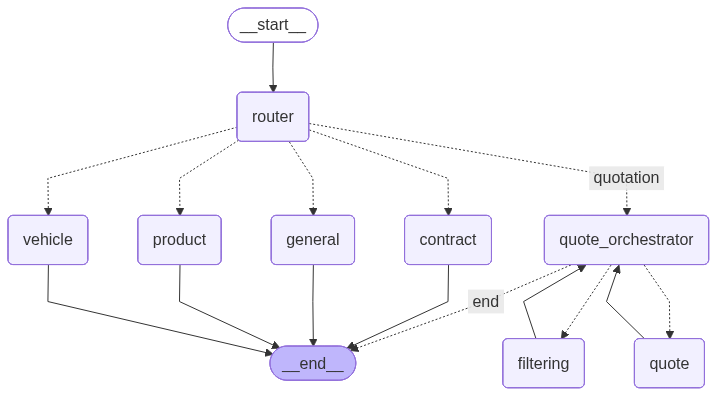

In [151]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [152]:
DEFAULT_STATE: AgentState = {
    "query": "",
    "route": [],
    "product_vector_result": "",
    "vehicle_vector_result": "",
    "contract_vector_result": "",
    "rewritten_query": "",
    "contract_filters": "",
    "vehicle_filters": "",
    "product_filters": "",
    "final_answer": "",
    "trace": [],
    "customer_id": "",
    "quote_step": "preowned",  # you can adjust initial step
    "quote_filters": {},
    "quote_vehicle_candidates": [],
    "quote_product_candidates": [],
    "quote_final_vehicle": None,
    "quote_final_product": None,
    "quote": None,
    "quote_intermediate_results": "",
    "quote_next_agent": "",
    "quote_context": "",
    "quote_completed": False,
    "quote_results":""
}

In [153]:
def stream(state):
    # Router node runs only once
    state.update(route_node(state))
    yield {"router": state}

    while state.get("step") != "quotation_end":
        next_agent = state.get("quote_next_agent", "")

        if next_agent == "filtering":
            state.update(filtering_node(state))
            yield {"filtering": state}
            
            # User input handled here
            if state.get("awaiting_user_input", False):
                user_inp = input("Your choice: ")
                state.update(update_state(state, user_inp))
                state["awaiting_user_input"] = False

        elif next_agent == "quote":
            state.update(quote_node(state))
            yield {"quote": state}

        elif next_agent in ["contract", "vehicle", "product"]:
            node_func = {
                "contract": contract_node,
                "vehicle": vehicle_node,
                "product": product_node
            }[next_agent]
            state.update(node_func(state))
            yield {next_agent: state}
            break  # final answer reached

        elif next_agent == "end":
            break
        else:
            state.update(general_node(state))
            yield {"general": state}

    yield {"final": state}


In [154]:
state = {**DEFAULT_STATE, "customer_id": "CUST-001", "quote_context": "vehicle"}
query = input("Enter your query (or 'exit' to quit): ")
if query.lower() == "exit":
    exit()

state["query"] = query
state["trace"] = []

# Initialize route only once based on query
state["route"] = ["quotation"]

completed = False
stream_gen = stream(state)  # use the updated generator

for s in stream_gen:
    print(s)  # debug output

    # Print outputs dynamically
    for key in ["router", "filtering", "quote", "contract", "vehicle", "product", "final"]:
        if key in s:
            node_state = s[key]
            if key == "filtering":
                print("Bot:", node_state.get("quote_results", ""))
            elif key == "quote":
                print("Bot:", node_state.get("quote_results", ""))
            elif key in ["contract", "vehicle", "product"]:
                print("Bot:", node_state.get("final_answer", ""))
                completed = True
            elif key == "final":
                print("Final State:", node_state)
                print("Final Answer:", node_state.get("final_answer", ""))
                completed = True

    if completed:
        break


rewritten_query='I would like to request a leasing quotation.' contract_filters='' vehicle_filters='' product_filters='' route=['quotation']
{'router': {'query': 'quotation', 'route': ['quotation'], 'product_vector_result': '', 'vehicle_vector_result': '', 'contract_vector_result': '', 'rewritten_query': 'I would like to request a leasing quotation.', 'contract_filters': '', 'vehicle_filters': '', 'product_filters': '', 'final_answer': '', 'trace': [['ROUTER', "Query='quotation' → Route='['quotation']'"]], 'customer_id': 'CUST-001', 'quote_step': 'preowned', 'quote_filters': {}, 'quote_vehicle_candidates': [], 'quote_product_candidates': [], 'quote_final_vehicle': None, 'quote_final_product': None, 'quote': None, 'quote_intermediate_results': '', 'quote_next_agent': '', 'quote_context': 'vehicle', 'quote_completed': False, 'quote_results': ''}}
{'general': {'query': 'quotation', 'route': ['quotation'], 'product_vector_result': '', 'vehicle_vector_result': '', 'contract_vector_result': 

KeyboardInterrupt: 

In [137]:
state = {**DEFAULT_STATE, "customer_id": "CUST-001","quote_context": "vehicle"}
completed = False
query = input("Enter your query (or 'exit' to quit): ")
print("User:", query)

# Set query and reset trace
state["query"] = query
state["trace"] = []


for s in app.stream(state):
    print(s)
    if "orchestrator_agent" in s:
        state.update(s["orchestrator_agent"])
        state = s["orchestrator_agent"]
        if state["step"]=="quotation_end":
            print("Flow ended.")
            completed = True  # set flag to exit outer loop
            break

    elif "filtering" in s:
        print("In filtering")
        state.update(s["filtering"])
        state = s["filtering"]
        print("Bot:", state["quote_results"])
        # capture user input here
        user_inp = input("Your choice: ")
        print("user:", user_inp)
        state.update(update_state(state, user_inp))

    elif "quote" in s:
        print("In Quote")
        state.update(s["quote"])
        state = s["quote"]
        print("Bot:", state["quote_results"])
        
    elif any(k in s for k in ["contract", "vehicle", "product"]):
        # Get the matching key
        key = next(k for k in ["contract", "vehicle", "product"] if k in s)
        state=s[key]
        print("Bot:", state["final_answer"])
        completed=True
        break

User: quotation
rewritten_query='I would like to request a leasing quotation.' contract_filters='' vehicle_filters='' product_filters='' route=['quotation']
{'router': {'query': 'quotation', 'route': ['quotation'], 'product_vector_result': '', 'vehicle_vector_result': '', 'contract_vector_result': '', 'rewritten_query': 'I would like to request a leasing quotation.', 'contract_filters': '', 'vehicle_filters': '', 'product_filters': '', 'final_answer': '', 'trace': [['ROUTER', "Query='quotation' → Route='['quotation']'"]], 'customer_id': 'CUST-001', 'quote_step': 'preowned', 'quote_filters': {}, 'quote_vehicle_candidates': [], 'quote_product_candidates': [], 'quote_final_vehicle': None, 'quote_final_product': None, 'quote': None, 'quote_intermediate_results': '', 'quote_next_agent': '', 'quote_context': 'vehicle', 'quote_completed': False, 'quote_results': ''}}
{'quote_orchestrator': {'query': 'quotation', 'route': ['quotation'], 'product_vector_result': '', 'vehicle_vector_result': '',

KeyboardInterrupt: Interrupted by user

In [52]:
# ---- Print Trace Table ----
print("\n--- Execution Trace ---")
print(tabulate(result["trace"], headers=["Node", "Output"], tablefmt="grid"))


--- Execution Trace ---
+----------------+------------------------------------------------------------+
| Node           | Output                                                     |
+================+============================================================+
| ROUTER         | Query='Suggest SUV Plans' → Route='['vehicle', 'product']' |
+----------------+------------------------------------------------------------+
| PRODUCT VECTOR | Retrieved 1445 docs                                        |
+----------------+------------------------------------------------------------+
| PRODUCT ANSWER | Here are some SUV leasing plans you can consider:          |
|                |                                                            |
|                | 1. **Toyota SUV Lease Plan (F...                           |
+----------------+------------------------------------------------------------+


In [ ]:
s= {"vehicle":"Sa"}
if ("contract" or "vehicle" or "product") in s:
            print("sa")

sa
